In [ ]:
import numpy as np

def create_square_wave(frequency, amplitude, duration, sampling_rate):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    wave = amplitude * np.sign(np.sin(2 * np.pi * frequency * t)).astype(float)
    return t, wave

# Example usage:
frequency = 261.6  # Hz
amplitude = 1.0  # Unit
duration = 5.0   # Second
sampling_rate = 44100  # Hz

t, wave = create_square_wave(frequency, amplitude, duration, sampling_rate)

In [1]:
import numpy as np

def create_mixed_wave(frequencies, amplitude, duration, sampling_rate):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    wave = np.zeros_like(t)
    for freq in frequencies:
        wave += amplitude * np.sin(2 * np.pi * freq * t)
    return t, wave

# Example usage:
middle_c = 261.6  # Hz
semitone = 2 ** (1 / 12)
frequencies = [(middle_c * semitone ** i) for i in range(10)]
amplitude = 0.1  # Unit
duration = 5  # Seconds
sampling_rate = 44100  # Hz

t, wave = create_mixed_wave(frequencies, amplitude, duration, sampling_rate)

In [9]:
def create_static_noise(amplitude, duration, sampling_rate):
    num_samples = int(duration * sampling_rate)
    noise = amplitude * np.random.uniform(-1, 1, num_samples)
    t = np.linspace(0, duration, num_samples, endpoint=False)
    return t, noise

# Example usage:
duration = 5.0  # Seconds
sampling_rate = 44100  # Hz
noise_amplitude = 1.0  # Unit
t, wave = create_static_noise(noise_amplitude, duration, sampling_rate)

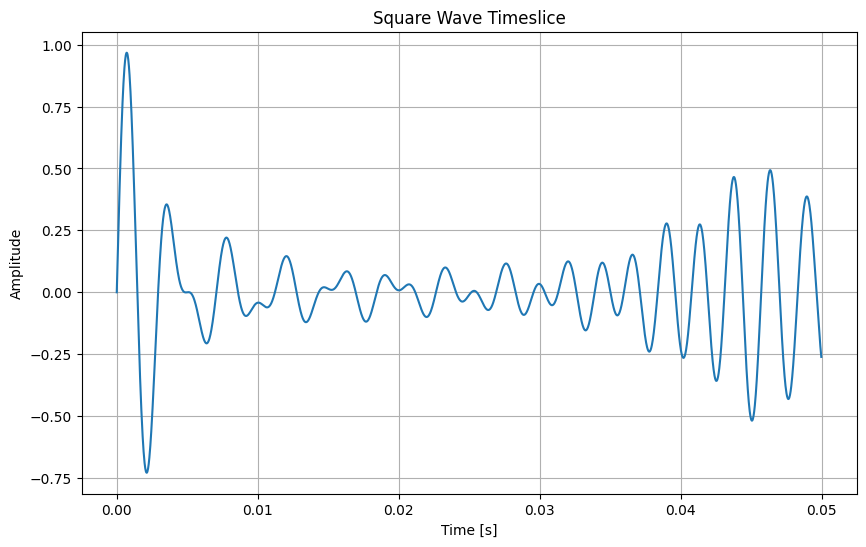

In [2]:
import matplotlib.pyplot as plt
# Define the timeslice range (e.g., from 0 to 0.01 seconds)
start_time = 0
end_time = 0.05

# Find the indices corresponding to the start and end times
start_index = int(start_time * sampling_rate)
end_index = int(end_time * sampling_rate)

# Slice the time and wave arrays
t_slice = t[start_index:end_index]
wave_slice = wave[start_index:end_index]

# Plot the timeslice
plt.figure(figsize=(10, 6))
plt.plot(t_slice, wave_slice)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Square Wave Timeslice')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np

def butter_bandpass(lowcut, highcut, fs, order=4):
    """
    Designs a 4th order (order=4) Butterworth bandpass filter by cascading two
    second-order (biquad) sections. The Q values for the biquads are chosen so that
    the overall filter has a maximally flat (Butterworth) response.
    
    Parameters:
      lowcut : low cutoff frequency in Hz
      highcut: high cutoff frequency in Hz
      fs     : sampling rate in Hz
      order  : filter order (must be even for this cascade implementation;
               here we assume order=4 so that we have two second-order sections)
               
    Returns:
      b, a : NumPy arrays containing the overall numerator and denominator coefficients.
    """
    if order != 4:
        raise NotImplementedError("This example implements only a 4th-order filter.")

    # Calculate the center frequency (geometric mean) and the bandwidth.
    f0 = np.sqrt(lowcut * highcut)
    bw = highcut - lowcut

    # For a Butterworth bandpass, the two second-order sections (biquads)
    # have different Q factors. (These can be derived from the 4th order Butterworth
    # pole angles. For order=4, the poles lie at angles π/8 and 3π/8.)
    Q1 = 1 / (2 * np.cos(np.pi/8))    # ≈ 0.5412
    Q2 = 1 / (2 * np.cos(3*np.pi/8))   # ≈ 1.3066

    def biquad_section(f0, Q, fs):
        """
        Returns the coefficients for a 2nd-order bandpass section.
        Uses the common “Audio EQ Cookbook” formulas.
        """
        omega = 2 * np.pi * f0 / fs
        sin_omega = np.sin(omega)
        cos_omega = np.cos(omega)
        alpha = sin_omega / (2 * Q)
        
        # The bandpass (constant skirt gain) biquad section has:
        b0 =   alpha
        b1 =   0.0
        b2 =  -alpha
        a0 =   1 + alpha
        a1 =  -2 * cos_omega
        a2 =   1 - alpha
        
        # Normalize coefficients so that a0 == 1.
        return np.array([b0, b1, b2]) / a0, np.array([1, a1/a0, a2/a0])
    
    # Compute coefficients for the two biquad sections.
    b1, a1 = biquad_section(f0, Q1, fs)
    b2, a2 = biquad_section(f0, Q2, fs)
    
    # Cascade the two sections by convolving the numerator and denominator polynomials.
    b = np.convolve(b1, b2)
    a = np.convolve(a1, a2)
    return b, a


In [2]:
def lfilter(b, a, x, zi=None):
    """
    Apply a linear filter to a 1D input signal x using the Direct Form II Transposed structure.
    
    Parameters:
      b : array_like
          The numerator (feedforward) coefficients of the filter.
      a : array_like
          The denominator (feedback) coefficients of the filter. a[0] must be nonzero.
      x : array_like
          The input signal array.
      zi : array_like, optional
          Initial conditions for the filter delays. If not provided, zeros are used.
          Its length should be max(len(a), len(b)) - 1.
    
    Returns:
      y : ndarray
          The output signal after filtering.
      zf : ndarray
          The final filter state (to be used as the initial condition for subsequent filtering if desired).
    
    Notes:
      This implementation uses a Direct Form II Transposed structure.
      It first pads the coefficient arrays if necessary and normalizes them so that a[0] == 1.
    """
    b = np.asarray(b, dtype=float)
    a = np.asarray(a, dtype=float)
    x = np.asarray(x, dtype=float)
    
    # Determine the length of the filter state:
    n_states = max(len(a), len(b)) - 1

    # Initialize state vector if not provided:
    if zi is None:
        state = np.zeros(n_states, dtype=float)
    else:
        state = np.asarray(zi, dtype=float)
        if state.size != n_states:
            raise ValueError("Initial condition zi must have length max(len(a), len(b)) - 1.")
    
    # Pad b and a to length n_states+1 if they are shorter:
    if len(b) < n_states + 1:
        b = np.concatenate((b, np.zeros(n_states + 1 - len(b))))
    if len(a) < n_states + 1:
        a = np.concatenate((a, np.zeros(n_states + 1 - len(a))))
    
    # Normalize coefficients if a[0] is not 1:
    if a[0] != 1.0:
        b = b / a[0]
        a = a / a[0]
    
    N = len(x)
    y = np.empty(N, dtype=float)
    
    # Process the input signal sample-by-sample:
    for n in range(N):
        # Compute current output:
        # For Direct Form II Transposed, output is:
        #   y[n] = b[0] * x[n] + state[0]
        y[n] = b[0] * x[n] + (state[0] if n_states > 0 else 0.0)
        
        # Update the state vector:
        if n_states > 0:
            # Shift the state: update state[0] to state[n_states-2] in one go.
            state[:-1] = state[1:] + b[1:-1] * x[n] - a[1:-1] * y[n]
            # Update the last state element:
            state[-1] = b[-1] * x[n] - a[-1] * y[n]
    
    # Return the filtered output and the final state
    return y, state


In [ ]:
# Define the Butterworth filter
order = 4
lowcut = 300.0  # Hz
highcut = 500.0  # Hz
nyquist = 0.5 * sampling_rate
frame_size = 512
low = lowcut / nyquist
high = highcut / nyquist
b, a = butter_bandpass(lowcut, highcut, sampling_rate, order=4)

# Process the stream in batches
streamed_data = wave
filtered_stream = np.zeros_like(streamed_data)
num_frames = len(streamed_data) // frame_size

# Initialize the filter state
zi = np.zeros((max(len(a), len(b)) - 1,))

for i in range(num_frames):
    start = i * frame_size
    end = start + frame_size
    filtered_stream[start:end], zi = lfilter(b, a, streamed_data[start:end], zi=zi)

# If there are remaining samples that don't fit into a full frame, process them as well
if len(streamed_data) % frame_size != 0:
    start = num_frames * frame_size
    filtered_stream[start:], _ = lfilter(b, a, streamed_data[start:], zi=zi)

# filtered_stream now contains the filtered audio data

In [14]:

def my_firwin(numtaps, cutoff, pass_zero=True, window='hamming'):
    """
    A basic implementation of firwin using the windowed sinc method.
    
    Parameters:
      numtaps   : int
                  The number of filter coefficients (taps). For symmetric FIR filters,
                  numtaps is typically odd.
      cutoff    : float or list/tuple of two floats
                  The cutoff frequency (or frequencies) as a fraction of the Nyquist rate.
                  For a lowpass or highpass filter, a single float is expected.
                  For a bandpass or bandstop filter, supply [f1, f2].
      pass_zero : bool, default True
                  If True, design a filter that passes the zero frequency (lowpass or bandstop).
                  If False, design a filter that has a zero at DC (highpass or bandpass).
      window    : str or array_like, default 'hamming'
                  Desired window to apply. A string such as 'hamming', 'hann', or 'blackman'
                  can be used, or a custom window array of length numtaps.
    
    Returns:
      h         : 1D numpy array
                  The FIR filter coefficients.
    
    Notes:
      For a lowpass filter with cutoff f (normalized to the Nyquist frequency), the ideal
      impulse response is:
      
         h[n] = sin(pi * f * (n - M)) / (pi * (n - M))   for n != M
         h[M] = f                                        for n = M
      
      For a highpass filter, we use the spectral inversion:
      
         h_hp[n] = δ[n-M] - h_lowpass[n]
      
      For bandpass and bandstop filters, we form them by combining two lowpass responses.
    """
    
    # Create an array of indices
    n = np.arange(numtaps)
    M = (numtaps - 1) / 2.0  # center index (assumes symmetric FIR)

    # For numerical stability, use np.sinc which is defined as sin(pi*x)/(pi*x)
    # Note that our ideal lowpass impulse response for cutoff f is:
    #    h[n] = f * np.sinc(f*(n-M))
    # which gives h[M] = f.
    def lowpass_impulse_response(f):
        return f * np.sinc(f * (n - M))
    
    # Design filter based on whether cutoff is a scalar or two-element sequence.
    if np.isscalar(cutoff):
        f = cutoff  # cutoff frequency (normalized)
        if pass_zero:
            # Lowpass filter
            h = lowpass_impulse_response(f)
        else:
            # Highpass filter via spectral inversion:
            #   h_hp[n] = δ[n-M] - h_lowpass[n]
            h = np.zeros(numtaps)
            h[int(M)] = 1.0  # delta impulse at the center index
            h -= lowpass_impulse_response(f)
    else:
        # When cutoff is a sequence, expect two frequencies: [f1, f2]
        f1, f2 = cutoff
        if f1 > f2:
            f1, f2 = f2, f1
            pass_zero = not pass_zero  # Invert the filter type for band-reject
        
        if pass_zero:
            # Bandstop filter: "notch out" frequencies between f1 and f2.
            # Formed by spectral inversion of a bandpass filter.
            h = np.zeros(numtaps)
            h[int(M)] = 1.0
            h -= (lowpass_impulse_response(f2) - lowpass_impulse_response(f1))
        else:
            # Bandpass filter: difference of two lowpass filters.
            h = lowpass_impulse_response(f2) - lowpass_impulse_response(f1)
    
    # Apply window function. If a string is passed, use a standard window.
    if isinstance(window, str):
        if window.lower() == 'hamming':
            win = np.hamming(numtaps)
        elif window.lower() == 'hann':
            win = np.hanning(numtaps)
        elif window.lower() == 'blackman':
            win = np.blackman(numtaps)
        else:
            raise ValueError("Unsupported window type: {}".format(window))
    else:
        # Assume window is provided as an array-like of correct length.
        win = np.asarray(window)
        if win.shape[0] != numtaps:
            raise ValueError("Window length must equal numtaps")
    
    # Multiply the ideal impulse response by the window function
    h = h * win
    
    # For filters that pass DC (lowpass or bandstop), normalize the coefficients
    # so that the sum is one.
    if pass_zero:
        h = h / np.sum(h)
    
    return h

In [18]:
# Define the FIR filter with more taps
numtaps = 1001  # Increased number of taps in the FIR filter
lowcut = 300.0  # Hz
highcut = 400.0  # Hz
nyquist = 0.5 * sampling_rate
low = lowcut / nyquist
high = highcut / nyquist
frame_size = 512
b = my_firwin(numtaps, [low, high], pass_zero=False)

# Process the stream in batches
streamed_data = wave
filtered_stream = np.zeros_like(streamed_data)
num_frames = len(streamed_data) // frame_size

# Initialize the filter state
zi = np.zeros(numtaps - 1)

for i in range(num_frames):
    start = i * frame_size
    end = start + frame_size
    filtered_stream[start:end], zi = lfilter(b, [1.0], streamed_data[start:end], zi=zi)

# If there are remaining samples that don't fit into a full frame, process them as well
if len(streamed_data) % frame_size != 0:
    start = num_frames * frame_size
    filtered_stream[start:], _ = lfilter(b, [1.0], streamed_data[start:], zi=zi)

# filtered_stream now contains the filtered audio data


In [233]:
import sounddevice as sd

# Play the sound
sd.play(filtered_stream, samplerate=sampling_rate)
sd.wait()  # Wait until the sound has finished playing

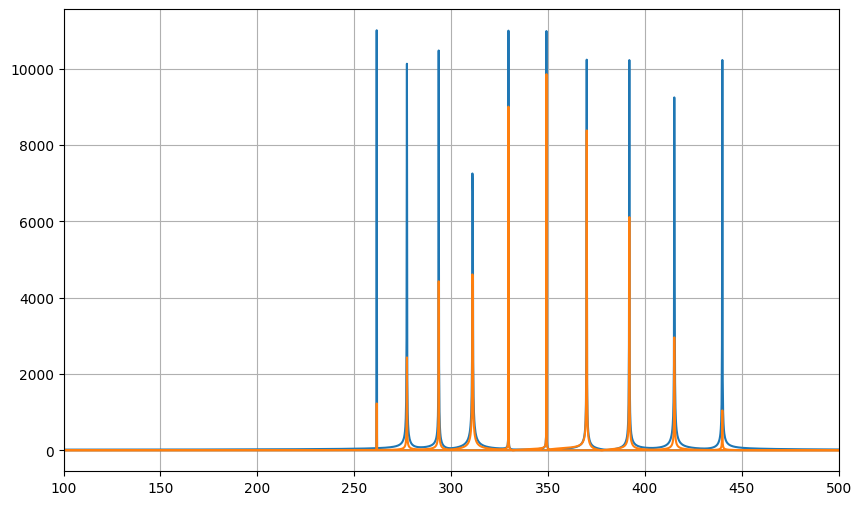

In [19]:
import matplotlib.pyplot as plt

# Compute the Fast Fourier Transform (FFT)
fft_wave = np.fft.fft(filtered_stream)
fft_freq = np.fft.fftfreq(len(filtered_stream), 1/sampling_rate)

# Compute the Fast Fourier Transform (FFT)
fft_wave_unfiltered = np.fft.fft(wave)
fft_freq_unfiltered = np.fft.fftfreq(len(wave), 1/sampling_rate)

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
plt.plot(fft_freq_unfiltered, np.abs(fft_wave_unfiltered))
plt.plot(fft_freq, np.abs(fft_wave))
plt.xlim(100, 500)  # Limit x-axis to twice the fundamental frequency for better visualization
plt.grid(True)
plt.show()

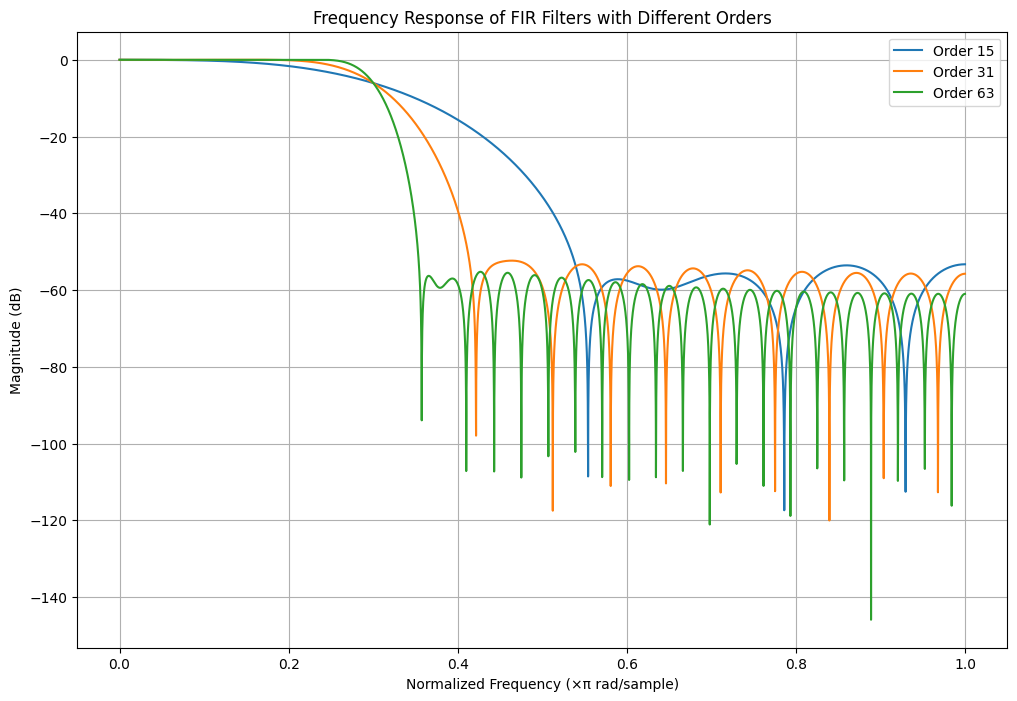

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz

# Design FIR filters of different orders
orders = [15, 31, 63]
cutoff = 0.3  # Normalized cutoff frequency (0.3 * Nyquist frequency)
filters = [firwin(order, cutoff) for order in orders]

# Plot frequency responses
plt.figure(figsize=(12, 8))
for order, filt in zip(orders, filters):
    w, h = freqz(filt, worN=8000)
    plt.plot(w / np.pi, 20 * np.log10(np.abs(h)), label=f'Order {order}')

plt.title('Frequency Response of FIR Filters with Different Orders')
plt.xlabel('Normalized Frequency (×π rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid()
plt.show()

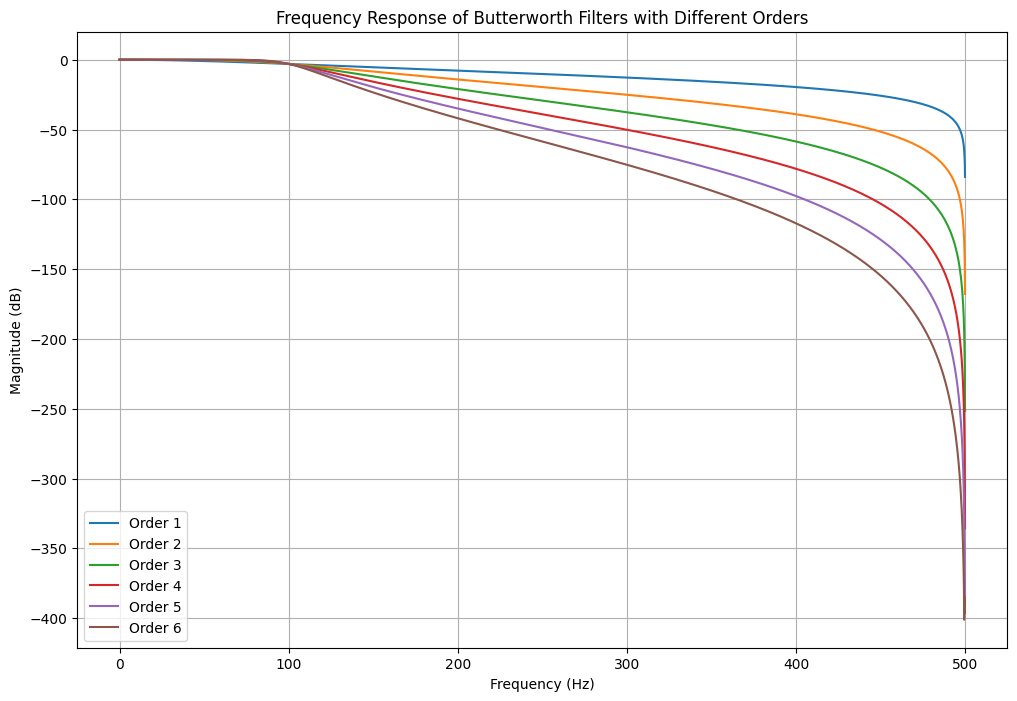

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, freqz

# Define the sampling rate and cutoff frequency
sampling_rate = 1000  # Hz
cutoff = 100  # Hz

# Design Butterworth filters of different orders
orders = [1, 2, 3, 4, 5, 6]
filters = [butter(order, cutoff / (0.5 * sampling_rate), btype='low', analog=False) for order in orders]

# Plot frequency responses
plt.figure(figsize=(12, 8))
for order, (b, a) in zip(orders, filters):
    w, h = freqz(b, a, worN=8000)
    plt.plot(0.5 * sampling_rate * w / np.pi, 20 * np.log10(np.abs(h)), label=f'Order {order}')

plt.title('Frequency Response of Butterworth Filters with Different Orders')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid()
plt.show()